In [2]:
###############
# some imports
###############
import ezdxf
import itertools
import k3d
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import meshio
import numpy as np
import pandas as pd
import pynoddy
from scipy.interpolate import griddata
import scipy.interpolate as interp
import sys, os
import subprocess
from shutil import copyfile
import time
import vtk
from vtkplotter import *
import PriorModelPlottingUtilty as util
util.importModulesAndSetup()
##############
# Some more imports after file fixes 
##############

import pynoddy.history
import pynoddy.experiment
import pynoddy.events

## Calculate the model

In [27]:
# load in the base history files (uncomment the desired model)

# Model with five faults three layers 
modelfile = 'ThreeLayerTrenton.his'

# DisplacementTransferZone (strike slip with normal faults on the edge)
#modelfile = 'DisplacementTransferZone.his'

# Two faults dipping in opposite direction (antithetic fault) 
#modelfile = 'antithetic_fault.his'

# Several faults, but there is some issue with this file
#modelfile = 'FirstSubsurfaceModel.his'

#Alter the mesh size if desiring to speed up the process. Recommended size is 100
output_name = 'noddy_out'
cubesize = 250
outputoption = 'ALL'
util.CalculateModel(modelfile, output_name, outputoption, cubesize)

## Now need to change the DXF file (mesh format) to VTK. This is slow unfortunately
dxf_parsed = util.getDXF_parsed_structure(output_name)

## Make a vtk file for each surface (option 1) or make a single vtk file for all surfaces (option 2)
outputOption = 1
nSurfaces, points = util.convertSurfaces2VTK(dxf_parsed, outputOption)

cube size is 250.0
b''
Finished calculating model
Finished reading model
The number of triangle elements (cells/faces) is: 107310
Finished converting dxf to vtk


## Get some information about your model

In [28]:
output_name = 'noddy_out'
N1 = pynoddy.output.NoddyOutput(output_name)

lithology = N1.block

[maxX, maxY, maxZ] = np.max(points, axis=0)

x = np.linspace(0, maxX, N1.nx, dtype=np.float32)
y = np.linspace(0, maxY, N1.ny, dtype=np.float32)
z = np.linspace(0, maxZ, N1.nz, dtype=np.float32)

delx = x[1]-x[0]
dely = y[1]-y[0]
delz = z[1]-z[0]

print("The model has an extent of %.0f m in x-direction, with %d cells of width %.0f m" %
      (maxX, N1.nx, delx))
print("The model has an extent of %.0f m in y-direction, with %d cells of width %.0f m" %
      (maxY, N1.ny, dely))
print("The model has an extent of %.0f m in z-direction, with %d cells of width %.0f m" %
      (maxZ, N1.nz, delz))

The model has an extent of 10000 m in x-direction, with 40 cells of width 256 m
The model has an extent of 8000 m in y-direction, with 32 cells of width 258 m
The model has an extent of 1300 m in z-direction, with 12 cells of width 118 m


In [29]:
## Some minor set up issue

xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

CoordXYZ = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1),zz.reshape(-1,1)), axis=1)

Lithology = griddata(CoordXYZ, np.transpose(lithology, axes =(2, 1, 0)).reshape(-1,), (xx, yy, zz), method='nearest')

## Plotting

In [30]:
embedWindow('k3d') #you can also choose to change to itkwidgets

plot = Plotter()
 
vol = Volume(Lithology, c='jet', spacing=[delx, dely,delz])

lego = vol.legosurface(-1, 4).opacity(0.2).c('jet')

plot += lego

colors = pl.cm.jet(np.linspace(0,1,nSurfaces))

#outputOption = 1

if(outputOption==1):
    for i in range(nSurfaces):
        filename = 'Surface'+str(i)+'.vtk'
        e=load(filename).c(colors[i, 0:3])

        plot += e
else:
    filename = 'Model.vtk'
    e=load(filename)
    plot += e

plot.show()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[5131.529464379659,…

## Changing around the model parameters

In [60]:
start = time.time()
H1 = pynoddy.history.NoddyHistory(modelfile)

H1.change_cube_size(250)
H1.events[3].properties['Dip'] = 40
H1.events[3].properties['X'] = 10000
H1.events[4].properties['Slip'] = 400
H1.events[5].properties['Dip'] = 90
H1.events[5].properties['X'] = 9000
H1.events[2].properties['Rotation'] = 40
H1.events[3].properties['Dip Direction'] = 26
H1.events[3].properties['Slip'] = 400

plot = Plotter()

includeGravityCalc = 1
util.CalculatePlotStructure(H1,plot, includeGravityCalc)
end = time.time()
print('Calculation time took '+str(end - start) + ' seconds')

plot.show()

cube size is 250.0
b''
Finished calculating model
Finished reading model
The number of triangle elements (cells/faces) is: 140049
Finished converting dxf to vtk
Calculation time took 16.33319592475891


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[6147.648230602334,…

## Some 2D plots

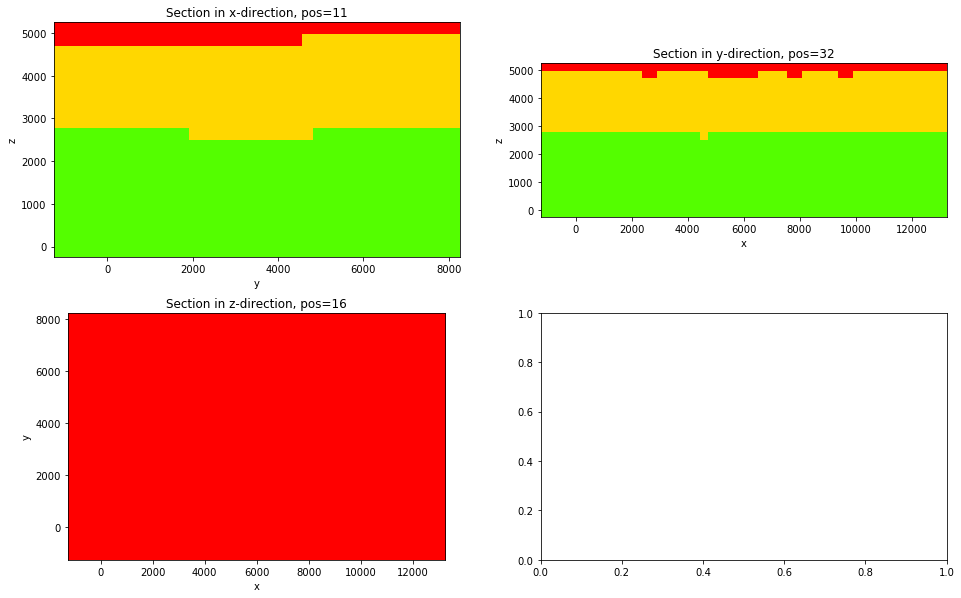

In [61]:
xslice = int(0.2*N1.nx)
yslice = int(0.9*N1.ny)
zslice = int(0.8*N1.nz)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))

## X slice
ax = axs[0,0]
N1.plot_section('x', position = xslice, ax = ax, cmap='prism')

## Y slice
ax = axs[0,1]
N1.plot_section('y', position = yslice, ax = ax, cmap='prism')

## Z slice
ax = axs[1,0]
N1.plot_section('z', position = zslice, ax = ax, cmap='prism')

### With Gravity

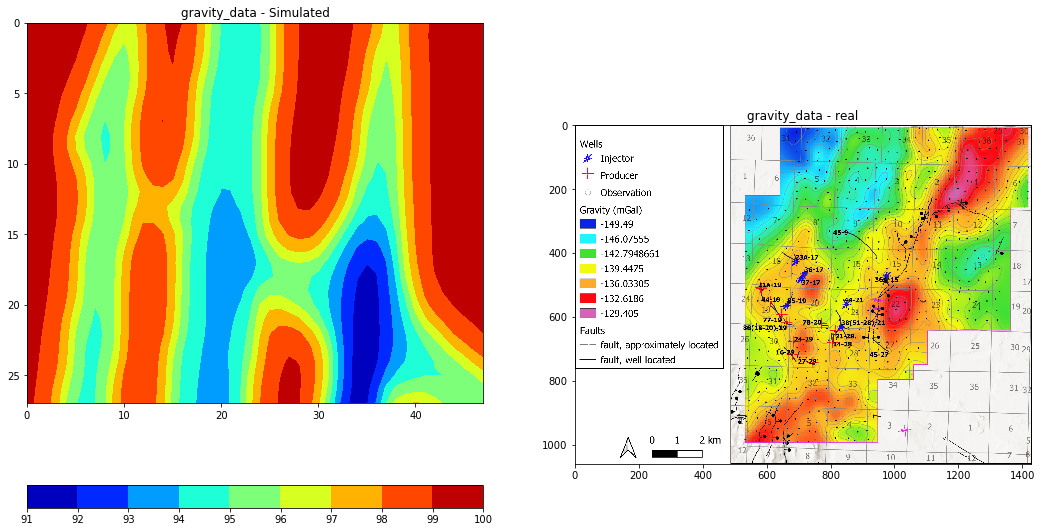

In [65]:
if(includeGravityCalc == 1):
    fileGeo = 'temp_noddy_out'
else:
    fileGeo = 'noddy_out'   

geophys = pynoddy.output.NoddyGeophysics(fileGeo)
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(121)
# imshow(geophys.grv_data, cmap = 'jet')
# define contour levels
levels = np.arange(322,344,1)
#cf = ax.contourf(geophys.grv_data, levels, cmap = 'gray', vmin = 324, vmax = 342)
cf = ax.contourf(geophys.grv_data, cmap = 'jet')
cbar = plt.colorbar(cf, orientation = 'horizontal')
# print levels
ax.set_title('gravity_data - Simulated')
plt.gca().invert_yaxis()

ax = fig.add_subplot(122)
img = mpimg.imread('GravityReal.png')
ax.set_title('gravity_data - real')
ax.imshow(img)

## Comparing granite top layers

In [68]:
Data = pd.read_csv('WellNamesPaths.csv')

saftyNum = 300
desiredMinX = 0+saftyNum
desiredMinY = 0+saftyNum
desiredMinZ = 0+saftyNum

desiredMaxX = maxX-saftyNum
desiredMaxY = maxY-saftyNum
desiredMaxZ = maxZ-saftyNum

Wells = Data.copy()
Wells['X'] = ((Data['X_m']- Data['X_m'].min())/(Data['X_m'].max()-Data['X_m'].min()))*(desiredMaxX-desiredMinX)+desiredMinX
Wells['Y'] = ((Data['Y_m']- Data['Y_m'].min())/(Data['Y_m'].max()-Data['Y_m'].min()))*(desiredMaxY-desiredMinY)+desiredMinY
Wells['Z'] = ((Data['Z_m']- Data['Z_m'].min())/(Data['Z_m'].max()-Data['Z_m'].min()))*(desiredMaxZ-desiredMinZ)+desiredMinZ

WellboreColors = N1.get_wellbore_voxels_from_paths(Wells['X'], Wells['Y'], Wells['Z'])
Wells['Colors'] = WellboreColors

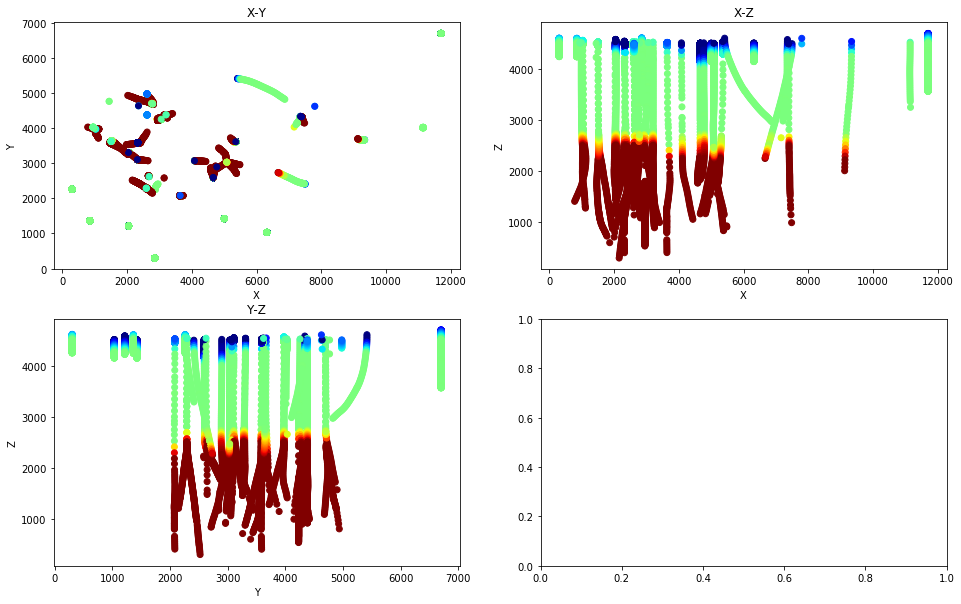

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 10))

ax = axs[0,0]
ax.scatter(Wells['X'], Wells['Y'], c=Wells['Colors'], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('X-Y')

ax = axs[0,1]
ax.scatter(Wells['X'], Wells['Z'], c=Wells['Colors'], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('X-Z')

ax = axs[1,0]
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_title('Y-Z')
ax.scatter(Wells['Y'], Wells['Z'], c=Wells['Colors'], cmap='jet')

In [69]:
modelfile

'ThreeLayerTrenton.his'

In [52]:
import importlib
importlib.reload(util)

<module 'PriorModelPlottingUtilty' from '/home/jovyan/PriorModelPlottingUtilty.py'>